In [1]:
# import go here
import sys
import os
sys.path.append(os.path.abspath('../..'))  # Add parent directory to path

from environment.knapsackgym import KnapsackEnv, _1_positive_reward, _1_negative_reward, v_i_positive_reward, vr_i_positive_reward, w_i_negative_reward, wr_i_negative_reward
from typing import List, Callable, Optional, Union, Tuple, Dict, Any
from models.DP_Knapsack_discrete import solve_knapsack_dp, solve_KP_instances_with_DP
from models.Greedy_Knapsack import solve_problem_instances_greedy
from models.KnapsackPPO import KnapsackPPOSolver
from models.KnapsackA2C import KnapsackA2C
from models.KnapsackQLearning import KnapsackDQN
from util.instance_gen import KnapsackInstanceGenerator
from util.metrics import evaluate_knapsack_performance
from models.KnapsackDRLSolver import KnapsackDRLSolver, run_KPSolver
from models.StateAggregator import StateAggregator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple, Callable
import time
import itertools
import pandas as pd


In [2]:
def run_experiment(
    KPSolver_A2C: KnapsackA2C,
    KPSolver_DQN: KnapsackDQN,
    KPSolver_PPO: KnapsackPPOSolver,
    instance_type,
    N,
    t_max,
    verbose=False):

    M = 1000
    seed = 42
    r_range = 100
    n_test_instances = 200

    # Generate problem instances
    gen = KnapsackInstanceGenerator(seed=seed)

    if verbose:
        print(f"Generating {M} {instance_type} training instances with N={N}, R={r_range}")

    if instance_type == "RI":
        training_instances = gen.generate_random_instances(M, N, r_range, seed=seed)
        test_instances = gen.generate_random_instances(n_test_instances, N, r_range, seed=seed+100)
    elif instance_type == "FI":
        training_instances = gen.generate_fixed_instances(M, N, seed=seed)
        test_instances = gen.generate_fixed_instances(n_test_instances, N, seed=seed+100)
    elif instance_type == "HI":
        training_instances = gen.generate_hard_instances(M, N, r_range, seed=seed)
        test_instances = gen.generate_hard_instances(n_test_instances, N, r_range, seed=seed+100)
    elif instance_type == "SS":
        training_instances = gen.generate_subset_sum_instances(M, N, r_range, seed=seed)
        test_instances = gen.generate_subset_sum_instances(n_test_instances, N, r_range, seed=seed+100)
    else:
        raise ValueError(f"Unknown instance type: {instance_type}")
    
    # Solve instances with DP and Greedy for baselines
    if verbose: print("Computing DP optimal solutions for training instances...")
    dp_sols_items_train, dp_values_train, dp_weight_train = solve_KP_instances_with_DP(training_instances)

    if verbose: print("Computing Greedy solutions for training instances...")
    greedy_values_train, greedy_sols_items_train, greedy_weights_train = solve_problem_instances_greedy(training_instances)
    
    if verbose: print("Computing DP optimal solutions for test instances...")
    dp_sols_items_test, dp_values_test, dp_weight_test = solve_KP_instances_with_DP(test_instances)
    
    if verbose:
        print("Computing Greedy solutions for test instances...")
    greedy_values_test, greedy_sols_items_test, greedy_weights_test = solve_problem_instances_greedy(test_instances)
    
    # Define models to test
    model_constructors = {}
    if KPSolver_A2C is not None: model_constructors["A2C"] = KPSolver_A2C
    if KPSolver_DQN is not None: model_constructors["DQN"] = KPSolver_DQN
    if KPSolver_PPO is not None: model_constructors["PPO"] = KPSolver_PPO

    aggregation_constructors = [True, False]

    results = {
        'training': {},
        'test': {},
        'metrics': {},
        'config': {
            'num_instances': M,
            'instance_type': instance_type,
            'n_items': N,
            'r_range': r_range,
            'seed': seed,
            't_max': t_max,
        }
    }

    # Total count of experiments
    total_experiments = len(aggregation_constructors) * len(model_constructors)

    if verbose:
        print(f"Running {total_experiments} experiments...")

    experiment_counter = 0
    
    # Run experiments for each model and reward function combination
    for model_name, model in model_constructors.items():
        results['training'][model_name] = {}
        results['test'][model_name] = {}
        results['metrics'][model_name] = {}
        
        for aggr_policy in aggregation_constructors:
            experiment_counter += 1
            aggr_desc = "with state aggregation" if aggr_policy else "without state aggregation"
            
            if verbose:
                print(f"\nExperiment {experiment_counter}/{total_experiments}: Testing {model_name} {aggr_desc}")
            
            # Create environment with specific reward functions
            env = KnapsackEnv(
                problem_instance=None,
                N=N
            )
            
            # Initialize the model
            kp_solver = model
            
            # Train the model
            start_time = time.time()
            
            solver, solution_values = run_KPSolver(
                env=env,
                KPSolver=kp_solver,
                training_problem_instances=training_instances,
                t_max=t_max,
                use_state_aggregation=aggr_policy,
                verbose=verbose
            )
            
            training_time = time.time() - start_time
            
            # Store training results
            results['training'][model_name][aggr_desc] = {
                'solution_values': solution_values,
                'training_time': training_time
            }
            
            # Evaluate on test instances
            test_values = []
            for instance in test_instances:
                env.change_problem_instance(instance)
                # value, weight, _ = kp_solver.solve(instance)
                value, weight, _ = solver.solve(instance)
                test_values.append(value)
            
            # Calculate performance metrics
            
            # For training instances
            train_best_values = solution_values['instance_best_values']
            train_metrics = evaluate_knapsack_performance(
                train_best_values, 
                dp_values_train, 
                greedy_values_train
            )
            
            # For test instances
            test_metrics = evaluate_knapsack_performance(
                test_values,
                dp_values_test,
                greedy_values_test
            )
            
            # Store test results and metrics
            results['test'][model_name][aggr_desc] = {
                'values': test_values,
                'metrics': test_metrics
            }
            
            results['metrics'][model_name][aggr_desc] = {
                'train': train_metrics,
                'test': test_metrics
            }
            
            if verbose:
                print(f"Training metrics for {model_name} with {aggr_desc}:")
                print(f"  Val/Opt Ratio: {train_metrics['ValOptRatio']:.2f}%")
                print(f"  #opt: {train_metrics['#opt']}/{M}")
                print(f"  Mean percentage error: {train_metrics['mean_percentage_error']:.4f}")
                print(f"  Mean improvement over greedy: {train_metrics['mean_improvement_over_greedy']:.4f}")
                
                print(f"Test metrics for {model_name} with {aggr_desc}:")
                print(f"  Val/Opt Ratio: {test_metrics['ValOptRatio']:.2f}%")
                print(f"  #opt: {test_metrics['#opt']}/{n_test_instances}")
                print(f"  Mean percentage error: {test_metrics['mean_percentage_error']:.4f}")
                print(f"  Mean improvement over greedy: {test_metrics['mean_improvement_over_greedy']:.4f}")

        # Generate summary table
        summary = create_summary_table(results)
        results['summary'] = summary
        
        # Generate visualizations
        # visualize_results(results)
        
        return results

def create_summary_table(results: Dict[str, Any]) -> pd.DataFrame:
    """
    Create a summary table of all experiments.
    
    Args:
        results: Results dictionary from test_reward_functions
        
    Returns:
        pd.DataFrame: Summary table
    """
    rows = []
    
    for model_name in results['metrics']:
        for reward_combo_name, metrics in results['metrics'][model_name].items():
            train_metrics = metrics['train']
            test_metrics = metrics['test']
            
            row = {
                'Model': model_name,
                'Method': reward_combo_name,
                'Train_ValOptRatio': train_metrics['ValOptRatio'],
                'GreedyOptRatio': train_metrics['ValGROptRatio'],
                'AveragedVal': train_metrics['AveragedVal'],
                'AveragedGrVal': train_metrics['AveragedGrVal'],
                'Train_#opt': train_metrics['#opt'],
                'Test_#opt': test_metrics['#opt'],
                'Greedy_#opt': test_metrics['#gr_opt'],
                'Train_#highest': test_metrics['#highest'],
                'Test_ValOptRatio': test_metrics['ValOptRatio']
            }

            rows.append(row)
    
    df = pd.DataFrame(rows)
    return df
    

In [3]:
instances = ["RI", "FI", "HI", "SS"]
Ns = [50, 100, 250]
t_max = 7500

# results = dict()
# for instance in instances:
#     results[instance] = dict()
#     for N in Ns:
#         KPSolver_A2C = KnapsackA2C(N=N, gamma=0.99, lr_policy=0.001, lr_value=0.001, verbose=True)
#         results[instance][N] = run_experiment(
#             KPSolver_A2C,
#             None,
#             None,
#             instance,
#             N,
#             t_max,
#             verbose=True
#         )

i, j = 2, 0

KPSolver_A2C = KnapsackA2C(N=Ns[j], gamma=0.99, lr_policy=0.001, lr_value=0.001, verbose=True)
results = run_experiment(
    KPSolver_A2C,
    None,
    None,
    instances[i],
    Ns[j],
    t_max,
    verbose=True
)

Generating 1000 HI training instances with N=50, R=100
Computing DP optimal solutions for training instances...
Solved instance 0 of 1000
Solved instance 100 of 1000
Solved instance 200 of 1000
Solved instance 300 of 1000
Solved instance 400 of 1000
Solved instance 500 of 1000
Solved instance 600 of 1000
Solved instance 700 of 1000
Solved instance 800 of 1000
Solved instance 900 of 1000
Computing Greedy solutions for training instances...
Computing DP optimal solutions for test instances...
Solved instance 0 of 200
Solved instance 100 of 200
Computing Greedy solutions for test instances...
Running 2 experiments...

Experiment 1/2: Testing A2C with state aggregation
Running Model <class 'models.KnapsackA2C.KnapsackA2C'>
Training on 1000 KP Instances, with N=50, t_max=7500


/media/m1ke-l/Data/McGill/COMP579/Project/COMP579FINALPROJECT/models/KnapsackA2C.py:236: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  next_states_tensor = torch.FloatTensor(next_states)


Iteration [0/7500], Training KP Instance 0, Reward: -23.683982430453884
Iteration [1000/7500], Training KP Instance 0, Reward: -23.683982430453888
Iteration [2000/7500], Training KP Instance 0, Reward: -23.683982430453884
Iteration [3000/7500], Training KP Instance 0, Reward: -23.683982430453884
Iteration [4000/7500], Training KP Instance 0, Reward: -23.683982430453888
Iteration [5000/7500], Training KP Instance 0, Reward: -23.683982430453888
Iteration [6000/7500], Training KP Instance 0, Reward: -23.683982430453884
Iteration [7000/7500], Training KP Instance 0, Reward: -23.68398243045388
Training metrics for A2C with with state aggregation:
  Val/Opt Ratio: 137.62%
  #opt: 1/1000
  Mean percentage error: 0.4854
  Mean improvement over greedy: -0.0521
Test metrics for A2C with with state aggregation:
  Val/Opt Ratio: 136.22%
  #opt: 0/200
  Mean percentage error: 0.5100
  Mean improvement over greedy: -0.0792

Experiment 2/2: Testing A2C without state aggregation
Running Model <class '

HI 50
  Model                     Method  Train_ValOptRatio  GreedyOptRatio  \
0   A2C     with state aggregation         137.623769      139.044821   
1   A2C  without state aggregation         137.430318      139.044821   

   AveragedVal  AveragedGrVal  Train_#opt  Test_#opt  Greedy_#opt  \
0     1538.792       1554.681           1          0            0   
1     1536.629       1554.681           1          0            0   

   Train_#highest  Test_ValOptRatio  
0              55        136.220240  
1              52        136.133553  


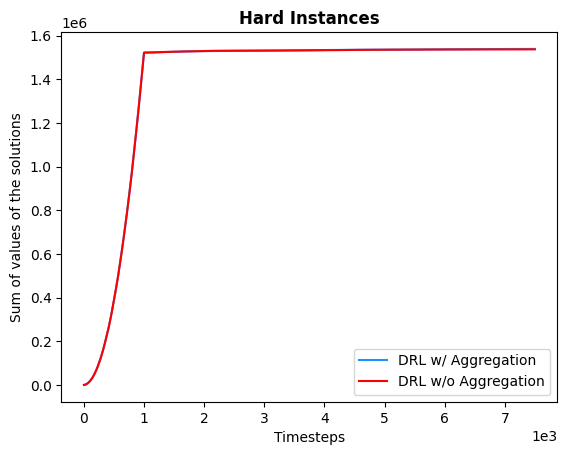

In [4]:
print(instances[i], Ns[j])
print(results['summary'])
plt.title('Hard Instances', weight='bold')
sum_aggr = results['training']['A2C']['with state aggregation']['solution_values']['best_sum_over_time']
sum_no_aggr = results['training']['A2C']['without state aggregation']['solution_values']['best_sum_over_time']
plt.plot(sum_aggr, label='DRL w/ Aggregation', color="dodgerblue")
plt.plot(sum_no_aggr, label='DRL w/o Aggregation', color="red")
plt.xlabel('Timesteps')
plt.ylabel('Sum of values of the solutions')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.show()

In [5]:
print("Time without aggregation", results['training']['A2C']['without state aggregation']['training_time'])
print("Time with aggregation", results['training']['A2C']['with state aggregation']['training_time'])

Time without aggregation 4107.271588563919
Time with aggregation 4881.281408786774
